<table style="width:100%; border-collapse: collapse;">
  <tr>
    <td style="width:20%; vertical-align:middle;">
      <img src="LogoUVG.png" width="400"/>
    </td>
    <td style="text-align:left; vertical-align:middle;">
      <h2 style="margin-bottom: 0;">Universidad del Valle de Guatemala - UVG</h2>
      <h3 style="margin-top: 0;">Facultad de Ingeniería - Computación</h3>
      <p style="font-size: 16px; margin-bottom: 0; margin-top: -10px">
        <strong>Curso:</strong> Responsible AI
        <strong>Sección:</strong> 10
        <strong>Repositorio:</strong> https://github.com/Dahernandezsilve/ResponsibleAI-Realworld-Data-Scraper
      </p>
      <p style="font-size: 16px; margin: 0;"><strong>Proyecto:</strong> Preprocesamiento de Datos</p>
      <br>
      <p style="font-size: 15px; margin: 0;"><strong>Autores:</strong></p>
      <ul style="margin-top: 5px; padding-left: 20px; font-size: 15px;">
        <li>Diego Alexander Hernández Silvestre - <strong>21270</strong></li>
        <li>Linda Inés Jiménez Vides - <strong>21169</strong></li>
        <li>Mario Antonio Guerra Morales - <strong>21008</strong></li>
        <li>Daniel Adolfo Sarmiento Peralta - <strong>231105</strong></li>
        <li>Kristopher Javier Alvarado López - <strong>21188</strong></li>
      </ul>
    </td>
  </tr>
</table>

# 🧼 Preprocesamiento

**Entrada:**  `data.json`  
**Salida:** `clean_data.csv` 
---
Este flujo unifica:
- Limpieza básica y normalización de direcciones (incluye Carretera a El Salvador y mapa de ciudades)
- Normalización de moneda y precios
- Tratamiento de nulos, outliers y zonas
- Generación de métricas de diagnóstico

In [1]:
import json
import unicodedata
from datetime import datetime
from typing import Optional, Dict
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format

## 📁 Parámetros iniciales y configuración

In [2]:
# Rutas y parámetros
data_path: str = "data.json"
id_col: str = "id"
null_col_threshold: float = 0.95      # columnas con >95% nulos se eliminan
outlier_quantile: float = 0.99        # p99 para filtrar outliers
date_cols = ["created_at", "updated_at"]

# Columnas técnicas / baja utilidad de negocio (se podan al inicio)
cols_drop_tech = [
    "price_change",
    "translated_title",
    "completed_step",
    "steps",
    "fts",
    "storage_path",
    "storage_path_original",
    "property_order",
    "storage_path_resize",
]

# Columnas específicas poco útiles para análisis
cols_drop_specific = ["slug", "zip", "logo", "coordinates"]

# Tasas de cambio (nota: si el período es largo, esto fija una foto en el tiempo)
conversion_rates: Dict[Optional[str], float] = {
    "USD": 7.82,
    "GTQ": 1.00,
    "MXN": 0.45,
    "DOP": 0.13,
    None: 1.00,
}

def log(msg: str) -> None:
    ts = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{ts}] {msg}")

## 🔧 Utilidades de texto y helpers

In [3]:
def strip_accents(s: str) -> str:
    return "".join(
        ch for ch in unicodedata.normalize("NFD", s)
        if unicodedata.category(ch) != "Mn"
    )

def collapse_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def clean_basic(value):
    if pd.isna(value):
        return None
    s = str(value).strip().lower()
    s = s.replace('"', "")             # quita comillas dobles
    s = collapse_spaces(s)
    return s

def pct(x: float) -> str:
    """Formato porcentaje corto."""
    return f"{100*x:.1f}%"

## 🌆 Normalización de ciudades (city_replace_map)
Map de errores comunes → forma oficial (con tildes correctas)

In [4]:
city_replace_map = {
    "guatemala city": "ciudad de guatemala",
    "guatemala": "ciudad de guatemala",
    "guatemala ": "ciudad de guatemala",
    "ciudad guatemala": "ciudad de guatemala",
    "ciudad de gutemala": "ciudad de guatemala",
    "ciudad de guatemala ": "ciudad de guatemala",
    "ciudad de panama": "panama",
    "guazacapan": "guazacapán",
    "esquintla": "escuintla",
    "san jose": "san josé",
    "palin": "palín",
    "san miguel duenas": "san miguel dueñas",
    "san lucas sacatepequez": "san lucas sacatepéquez",
    "suchitepequez": "suchitepéquez",
    "sacatepequez": "sacatepéquez",
    "quezaltenango": "quetzaltenango",
    "san juan sacatepequez": "san juan sacatepéquez",
    "mixco ": "mixco",
    "santa catarina pinula ": "santa catarina pinula",
}

def normalize_city(city_raw: str) -> str:
    if pd.isna(city_raw):
        return None # type: ignore
    s = clean_basic(city_raw)
    key = strip_accents(s) # type: ignore
    return city_replace_map.get(key, s) # type: ignore

## 🛣️ Normalización de *Carretera a El Salvador* (CES/CAES/C.A.E.S./Carr. a/Al)
Preserva Km si aparece antes o después, y el resto del contenido de la dirección.

In [5]:
# Patrones (km antes)
pattern_km_before = re.compile(r"""
    (?ix)
    \bkm\s*
    (?P<km>\d+(?:[.,]\d+)?)
    \b\s*[,;:/\.-]*\s*
    (?:c\.?\s*a\.?\s*e\.?\s*s\.?|caes|ces|
       carr\.?\s*(?:a|al)\s*el\s*salvador|
       carretera\s*(?:a\s*)?el\s*salvador|
       ruta\s*a\s*el\s*salvador)
    \b
""", re.VERBOSE)

# Patrones (km después)
pattern_km_after = re.compile(r"""
    (?ix)
    \b(?:c\.?\s*a\.?\s*e\.?\s*s\.?|caes|ces|
       carr\.?\s*(?:a|al)\s*el\s*salvador|
       carretera\s*(?:a\s*)?el\s*salvador|
       ruta\s*a\s*el\s*salvador)\b
    \s*[,;:/\.-]*\s*
    km\s*(?P<km>\d+(?:[.,]\d+)?)
    \b
""", re.VERBOSE)

# Patrones (sin km explícito)
pattern_no_km = re.compile(r"""
    (?ix)
    \b(c\.?\s*a\.?\s*e\.?\s*s\.?|caes|ces|
       carr\.?\s*(?:a|al)\s*el\s*salvador|
       carretera\s*(?:a\s*)?el\s*salvador|
       ruta\s*a\s*el\s*salvador)\b
""", re.VERBOSE)

def _km_norm(km: str) -> str:
    return km.replace(",", ".")

def normalize_ces_segment(text: str) -> str:
    if not isinstance(text, str):
        return text

    # Km ANTES
    def repl_before(m):
        km = _km_norm(m.group('km'))
        return f"Km {km} Carretera a El Salvador"

    new_text, _ = pattern_km_before.subn(repl_before, text)

    # Km DESPUÉS
    def repl_after(m):
        km = _km_norm(m.group('km'))
        return f"Carretera a El Salvador Km {km}"

    new_text, _ = pattern_km_after.subn(repl_after, new_text)

    # Sin Km
    new_text, _ = pattern_no_km.subn("Carretera a El Salvador", new_text)

    # Limpieza menor de separadores duplicados: ", ," -> ", ", etc.
    new_text = re.sub(r"\s{2,}", " ", new_text).strip()
    new_text = re.sub(r"\s*([,;:/.-])\s*", r"\1 ", new_text)   # espaciar separadores
    new_text = collapse_spaces(new_text)
    return new_text

## 📊 Perfilado rápido y utilidades de poda

In [6]:
def _auto_bins_numeric(s: pd.Series) -> int:
    s = s.dropna().astype(float)
    n = len(s)
    if n == 0:
        return 1
    # Freedman–Diaconis: h = 2*IQR / n^(1/3); k ≈ range / h
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    rng = s.max() - s.min()
    if iqr > 0 and rng > 0:
        h = 2 * iqr / (n ** (1/3))
        if h > 0:
            k = int(np.ceil(rng / h))
            if k >= 1:
                return min(k, 200)  # techo sano
    # Fallback: Sturges (1 + log2 n)
    k = int(np.ceil(1 + np.log2(n)))
    return max(1, min(k, 200))

def quick_profile(df: pd.DataFrame, cols, top_n: int = 10, datetime_freq: str = "M"):
    """
    Perfil rápido por columna:
      - Booleanas: conteo True/False/NA.
      - Numéricas: describe + cuantiles + bins automáticos (FD/Sturges) y conteo por bin.
      - Numéricas discretas (pocos únicos): tabla de frecuencias en vez de bins.
      - Datetime: rango y conteo por periodo (mes por defecto).
      - Categóricas: nunique, top categorías, cobertura.
    """
    for col in cols:
        print("-" * 40)
        s = df[col]
        print(f"=== {col} ===")
        print(f"dtype: {s.dtype}")
        miss = s.isna().mean()
        print(f"missing: {s.isna().sum()} ({miss:.2%})")

        # 1) Booleanos
        if s.dtype == bool or (pd.api.types.is_bool_dtype(s) and not pd.api.types.is_numeric_dtype(s)):
            vc = s.value_counts(dropna=False)
            print("\n[boolean counts]\n", vc)
            continue

        # 2) Datetime
        if pd.api.types.is_datetime64_any_dtype(s):
            if s.notna().any():
                print(f"min: {s.min()} | max: {s.max()}")
                grp = s.dt.to_period(datetime_freq).value_counts().sort_index()
                print(f"\n[count by period '{datetime_freq}']\n", grp.head(top_n))
            continue

        # 3) Numérica
        if pd.api.types.is_numeric_dtype(s):
            s_num = pd.to_numeric(s, errors="coerce")
            nunq = s_num.nunique(dropna=True)

            # Discreta (pocos únicos)
            if nunq <= 20:
                vc = s_num.value_counts(dropna=False).sort_index()
                print(f"nunique: {nunq} (discreta)")
                print("\n[value counts]\n", vc.head(top_n))
                print("\n[describe]\n", s_num.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).to_string())
                continue

            # Continua
            print(s_num.describe(percentiles=[.01,.05,.25,.5,.75,.95,.99]).to_string())
            try:
                print("\n[quantiles]\n", s_num.quantile([.01,.05,.25,.5,.75,.95,.99]))
            except Exception as e:
                print(f"\n[quantiles] omitidos: {e}")

            k = _auto_bins_numeric(s_num)
            binned = pd.cut(s_num, bins=k, include_lowest=True)
            print(f"\n[bins = {k} (auto)]\n", binned.value_counts().head(top_n))
            continue

        # 4) Categórica / texto
        nunq = s.nunique(dropna=True)
        print(f"nunique: {nunq}")
        vc = s.value_counts(dropna=False).head(top_n)
        coverage = vc.sum() / len(s)
        print("[top categorías]", vc)
        print(f"coverage top {top_n}: {coverage:.2%}")

def drop_by_prefixes(df_in: pd.DataFrame, prefixes) -> pd.DataFrame:
    """Elimina columnas raíz y sus anidados (p.ej. 'storage_path' y 'storage_path.*')."""
    cols = df_in.columns
    to_drop = []
    for p in prefixes:
        to_drop.extend([c for c in cols if c == p or c.startswith(p + ".")])
    to_drop = list(dict.fromkeys(to_drop))  # sin duplicados
    return df_in.drop(columns=to_drop, errors="ignore")

## 🧩 Carga de datos (JSON → DataFrame)

In [7]:
with open(data_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

df = pd.json_normalize(raw)
log(f"cargado → filas={df.shape[0]}, columnas={df.shape[1]}")

[2025-10-17 13:07:44] cargado → filas=8032, columnas=64


## 🪚 Limpieza estructural (poda, nulos, constantes, duplicados)

In [8]:
# 3.1 Poda técnica + 3.2 columnas específicas
df = drop_by_prefixes(df, cols_drop_tech)
df = df.drop(columns=[c for c in cols_drop_specific if c in df.columns], errors="ignore")

# 3.3 Columnas con >95% nulos
null_ratio = df.isna().mean()
high_null_cols = null_ratio[null_ratio > null_col_threshold].index.tolist()
if high_null_cols:
    df = df.drop(columns=high_null_cols).copy()
    log(f"poda por >{int(null_col_threshold*100)}% nulos → {high_null_cols}")

# 3.4 Columnas constantes
if "status" in df.columns and df["status"].nunique(dropna=False) <= 1:
    df = df.drop(columns=["status"]).copy()
    log("status eliminado (sin variación)")

log(f"post-poda → filas={df.shape[0]}, columnas={df.shape[1]}")

# Dedupe por id
if "id" in df.columns:
    dup = int(df.duplicated(subset=["id"], keep=False).sum())
    if dup:
        df = df.drop_duplicates(subset=["id"]).copy()
    log(f"duplicados por id eliminados → {dup}")
else:
    log("columna 'id' no existe → se omite deduplicación por id")

[2025-10-17 13:07:45] poda por >95% nulos → ['is_verified', 'project_id', 'terrain_type', 'bathroom_type', 'construction_permit', 'storage_space_msq', 'favourited_by']
[2025-10-17 13:07:45] status eliminado (sin variación)
[2025-10-17 13:07:45] post-poda → filas=8032, columnas=22
[2025-10-17 13:07:45] duplicados por id eliminados → 178


## 🕒 Fechas y métricas derivadas

In [9]:
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], utc=True, errors="coerce")

now = pd.Timestamp.now(tz="UTC")
if "created_at" in df.columns:
    df["days_since_created"] = (now - df["created_at"]).dt.days # type: ignore
    df["year_created"] = df["created_at"].dt.year

## 💱 Conversión de moneda y corrección de `price_gtq`

In [10]:
# Asegurar currency
if "currency" not in df.columns:
    df["currency"] = "GTQ"

df["currency"] = (
    df["currency"].astype(str).str.strip().str.upper()
      .str.replace(r"[^A-Z]", "", regex=True)
)

df["conversion_rate"] = df["currency"].map(conversion_rates)

mask_bad_curr = df["conversion_rate"].isna()
dropped_bad = int(mask_bad_curr.sum())
if dropped_bad:
    df = df.loc[~mask_bad_curr].copy()
    log(f"filas eliminadas por currency inválida/no mapeada → {dropped_bad}")

# Calcular price_gtq si es posible
price_num = pd.to_numeric(df["price"], errors="coerce")
price_gtq_calc = price_num * df["conversion_rate"]

if "price_gtq" not in df.columns:
    df["price_gtq"] = np.nan

RTOL, ATOL = 1e-4, 1e-2  # tolerancias para floats
pg = df["price_gtq"]

mask_fill_missing = (pg.isna() | (pg == 0)) & price_gtq_calc.notna()
mask_unconverted = (
    (df["currency"] != "GTQ")
    & pg.notna() & price_num.notna()
    & np.isclose(pg, price_num, rtol=RTOL, atol=ATOL)
    & price_gtq_calc.notna()
)
mask_already_ok = (
    pg.notna() & price_gtq_calc.notna()
    & np.isclose(pg, price_gtq_calc, rtol=RTOL, atol=ATOL)
)

updates = mask_fill_missing | (mask_unconverted & ~mask_already_ok)
df.loc[updates, "price_gtq"] = price_gtq_calc[updates]

log(f"price_gtq: rellenadas={int(mask_fill_missing.sum())}, corregidas_sin_convertir={int((mask_unconverted & ~mask_already_ok).sum())}")

# Outliers (p99)
if df["price_gtq"].notna().any():
    p99 = df["price_gtq"].quantile(outlier_quantile)
    n_before = df.shape[0]
    df = df[df["price_gtq"] <= p99].copy()
    log(f"outliers (>{int(outlier_quantile*100)}p) removidos → {n_before - df.shape[0]} (umbral={p99:,.2f})")
else:
    log("se omite p99: 'price_gtq' está vacío o todo es NaN")

[2025-10-17 13:07:45] filas eliminadas por currency inválida/no mapeada → 19
[2025-10-17 13:07:45] price_gtq: rellenadas=642, corregidas_sin_convertir=2
[2025-10-17 13:07:45] outliers (>99p) removidos → 79 (umbral=25,639,998.67)


## 🧩 Imputaciones: texto, categóricas y numéricas; métrica `price_per_m2` y lat y long

In [11]:
# Textos
for c in ["title", "address", "neighborhood"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown")

# Categóricas
if "property_type" in df.columns:
    df["property_type"] = df["property_type"].fillna("unknown")

# Numéricas por mediana de property_type (fallback a mediana global si el grupo es chico)
for c in ["bedroom_count", "bathroom_count", "size_msq"]:
    if c in df.columns:
        med_global = df[c].median(skipna=True)
        df[c] = df.groupby("property_type")[c].transform(
            lambda s: s.fillna(s.median() if s.dropna().size > 2 else med_global)
        )

# price_per_m2: solo con area válida
if {"size_msq", "price_gtq"}.issubset(df.columns):
    df["price_per_m2"] = np.where(
        (df["size_msq"] > 0) & df["price_gtq"].notna(),
        df["price_gtq"] / df["size_msq"],
        np.nan,
    )
    # criterio: eliminar registros sin price_per_m2 (área inválida/faltante)
    before = len(df)
    df = df.loc[df["price_per_m2"].notna()].copy()
    removed = before - len(df)
    if removed:
        log(f"filas eliminadas sin price_per_m2 → {removed}")

# lat/long: mediana por ciudad_clean con fallback global
for coord in ["lat", "long"]:
    if coord in df.columns:
        med_global = df[coord].median(skipna=True)
        key = "city" if "city" in df.columns else "city"
        df[coord] = df.groupby(key)[coord].transform(
            lambda s: s.fillna(s.median() if not np.isnan(s.median()) else med_global)
        )

# chequeo rápido
print("[diag_geo] lat NA=", df["lat"].isna().mean() if "lat" in df.columns else "n/a",
      "| long NA=", df["long"].isna().mean() if "long" in df.columns else "n/a")

[2025-10-17 13:07:45] filas eliminadas sin price_per_m2 → 27


c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Sc

[diag_geo] lat NA= 0.0 | long NA= 0.0


c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Scraper\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\lijv1.LINDA_HP\Documents\GitHub\ResponsibleAI-Realworld-Data-Sc

## 🧼 Limpieza y normalización de texto (city, neighborhood, address)

In [12]:
text_cols = [c for c in ["city", "neighborhood", "address"] if c in df.columns]

# 1) Limpieza básica in-place
for c in text_cols:
    df[c] = df[c].apply(clean_basic)

# 2) city → normalize_city (usa map con búsqueda sin acentos)
if "city" in df.columns:
    df["city"] = df["city"].apply(normalize_city)

# 3) CES/CAES/C.A.E.S./Carr... en neighborhood/address (mantiene el resto)
for c in ["neighborhood", "address"]:
    if c in df.columns:
        df[c] = df[c].apply(normalize_ces_segment)

# 4) Re-limpieza final (por si los reemplazos introdujeron espacios)
for c in text_cols:
    df[c] = df[c].apply(clean_basic)

    

## 🧭 Normalización de zonas (neighborhood → número si aplica)

In [13]:
def cleanNeighborhoods(s: pd.Series) -> pd.Series:
    """
    Limpia la columna 'neighborhood' dejando solo el número de zona si aplica.
    Ejemplo:
      'Zona 10' -> '10'
      'z. 14'   -> '14'
      '15'      -> '15'
      'Guatemala' -> 'Guatemala'
      '' o NaN   -> 'Unknown'
    """
    s2 = s.astype(str).str.strip()
    s2 = s2.replace({"": np.nan, "None": np.nan, "nan": np.nan})
    s2 = s2.fillna("Unknown")
    s2 = s2.str.replace(r"\s+", " ", regex=True)

    zonePattern = re.compile(r"""
        (?:
            \b(?:z|zona|z\.)\s*[-.:]?\s*   # prefijo opcional
        )?
        0*(\d{1,2})\b                     # número de 1–2 dígitos
    """, re.IGNORECASE | re.VERBOSE)

    def normalizeOne(x: str) -> str:
        raw = x.strip()
        if raw.lower() in {"", "unknown", "desconocido"}:
            return "Unknown"

        # Si es solo número
        m_num_only = re.fullmatch(r"0*(\d{1,2})", raw)
        if m_num_only:
            return m_num_only.group(1)

        # Si contiene 'zona' o variante
        m_zone = zonePattern.search(raw)
        if m_zone:
            n = int(m_zone.group(1))
            if 1 <= n <= 25:  # zonas válidas de Ciudad de Guatemala
                return str(n)

        # Si no es zona, se deja tal cual
        return raw

    s3 = s2.apply(normalizeOne)
    s3 = s3.str.strip()
    return s3

if "neighborhood" in df.columns:
    df["neighborhood"] = cleanNeighborhoods(df["neighborhood"])

## 🔎 Diagnóstico rápido y columnas

In [14]:
# a) NaN reales
total_na = int(df.isna().sum().sum())
# b) cadenas vacías en texto
empty_strings = 0
for c in df.select_dtypes(include=["object", "string"]).columns:
    empty_strings += int(df[c].astype(str).str.strip().eq("").sum())
# c) no finitos en numéricos
non_finite = 0
for c in df.select_dtypes(include=[np.number]).columns:
    non_finite += int((~np.isfinite(df[c])).sum())

diag = {
    "rows": df.shape[0],
    "cols": df.shape[1],
    "na_any": pct(df.isna().any(axis=1).mean()),
    "price_gtq_na": pct(df["price_gtq"].isna().mean()) if "price_gtq" in df else "n/a",
    "size_msq_na": pct(df["size_msq"].isna().mean()) if "size_msq" in df else "n/a",
    "lat_na": pct(df["lat"].isna().mean()) if "lat" in df else "n/a",
    "long_na": pct(df["long"].isna().mean()) if "long" in df else "n/a",
    "city_levels": df["city"].nunique(dropna=False) if "city" in df else "n/a",
    "total_na_cells": total_na,
    "empty_strings": empty_strings,
    "non_finite_nums": non_finite,
}
print("[diag]", diag)

# Mostrar nombres de columnas
for col in df:
    print(col)

[diag] {'rows': 7818, 'cols': 26, 'na_any': '0.0%', 'price_gtq_na': '0.0%', 'size_msq_na': '0.0%', 'lat_na': '0.0%', 'long_na': '0.0%', 'city_levels': 229, 'total_na_cells': 0, 'empty_strings': 748, 'non_finite_nums': 0}
id
created_at
updated_at
property_type
type
address
title
listed_by_id
archived
active
city
neighborhood
currency
lat
long
price
price_gtq
bedroom_count
bathroom_count
size_msq
available_parking_spaces
favourite_count
days_since_created
year_created
conversion_rate
price_per_m2


# 🔍 Inspección individual de columnas (perfilado rápido)

In [15]:
cols = ["archived", "listed_by_id", "favourite_count", "active"]
quick_profile(df, cols, top_n=10)

----------------------------------------
=== archived ===
dtype: bool
missing: 0 (0.00%)

[boolean counts]
 archived
False    7818
Name: count, dtype: int64
----------------------------------------
=== listed_by_id ===
dtype: object
missing: 0 (0.00%)
nunique: 105
[top categorías] listed_by_id
7a893440-988f-4fcc-b8dc-21bc04de33e1    1751
e1353d42-be5e-432b-853a-a4083e4ec126     687
9169e2fd-4724-4a90-8bdc-3d4fdff72f73     630
f88e1b8c-f3c5-432b-99a3-a6687a5a4588     544
63e79171-29a1-482a-a0df-29a314b0b357     508
585fb986-e360-4894-a21a-aaa31dbfdf82     413
98f51467-5a95-4383-9202-41900ff513d2     338
1f7004b0-84c6-4394-bf89-3e363f1c6009     337
8e46fb29-bca3-44d6-93d4-f004c7950eb6     336
c728750e-bfc0-4470-9a6f-ee3d91665e0d     247
Name: count, dtype: int64
coverage top 10: 74.07%
----------------------------------------
=== favourite_count ===
dtype: int64
missing: 0 (0.00%)
nunique: 4 (discreta)

[value counts]
 favourite_count
0    7580
1     217
2      13
3       8
Name: count, 

In [16]:
df = df.drop(columns=cols)

In [17]:
diag = {
    "rows": df.shape[0],
    "cols": df.shape[1],
    "na_any": pct(df.isna().any(axis=1).mean()),
    "price_gtq_na": pct(df["price_gtq"].isna().mean()) if "price_gtq" in df else "n/a",
    "size_msq_na": pct(df["size_msq"].isna().mean()) if "size_msq" in df else "n/a",
    "lat_na": pct(df["lat"].isna().mean()) if "lat" in df else "n/a",
    "long_na": pct(df["long"].isna().mean()) if "long" in df else "n/a",
    "city_levels": df["city"].nunique(dropna=False) if "city" in df else "n/a",
    "total_na_cells": total_na,
    "empty_strings": empty_strings,
    "non_finite_nums": non_finite,
}
print("[diag]", diag)

[diag] {'rows': 7818, 'cols': 22, 'na_any': '0.0%', 'price_gtq_na': '0.0%', 'size_msq_na': '0.0%', 'lat_na': '0.0%', 'long_na': '0.0%', 'city_levels': 229, 'total_na_cells': 0, 'empty_strings': 748, 'non_finite_nums': 0}


## 💾 Exportar dataset limpio

In [18]:
# Exporta a CSV (UTF-8). Si prefieres Parquet, puedes agregar try/except aquí.
df.to_csv("clean_data.csv", index=False, encoding="utf-8")
print("✅ Archivo exportado: clean_data.csv")

✅ Archivo exportado: clean_data.csv


## 📊 Visualización de resultados

In [19]:
df = pd.read_csv("clean_data.csv")

df["created_at"] = pd.to_datetime(df.get("created_at"), errors="coerce")
df["year_created"] = df["created_at"].dt.year
for c in ["price_gtq", "price_per_m2", "size_msq"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

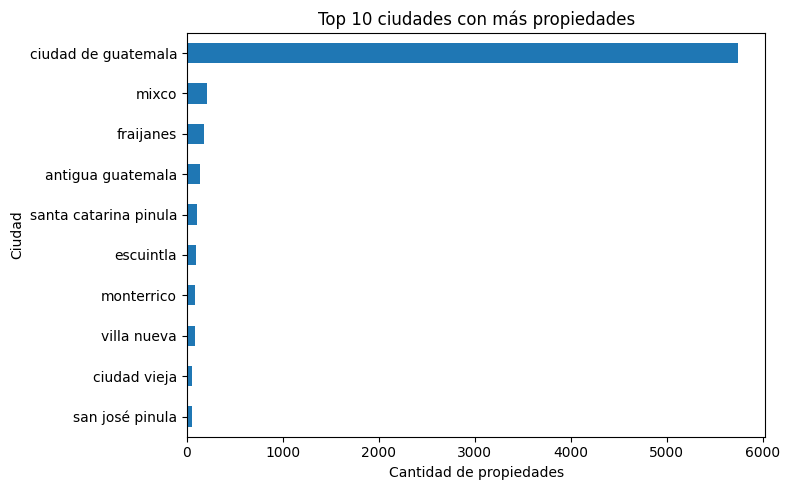

In [20]:
plt.figure(figsize=(8, 5))
vc = df["city"].value_counts().head(10)
vc.iloc[::-1].plot(kind="barh")
plt.xlabel("Cantidad de propiedades")
plt.ylabel("Ciudad")
plt.title("Top 10 ciudades con más propiedades")
plt.tight_layout()
plt.show()


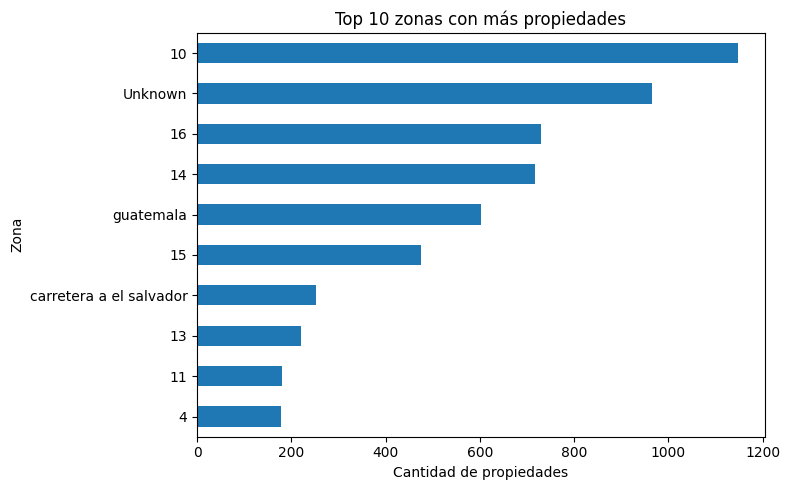

In [21]:
plt.figure(figsize=(8, 5))
vb = df["neighborhood"].value_counts().head(10)
vb.iloc[::-1].plot(kind="barh")
plt.xlabel("Cantidad de propiedades")
plt.ylabel("Zona")
plt.title("Top 10 zonas con más propiedades")
plt.tight_layout()
plt.show()


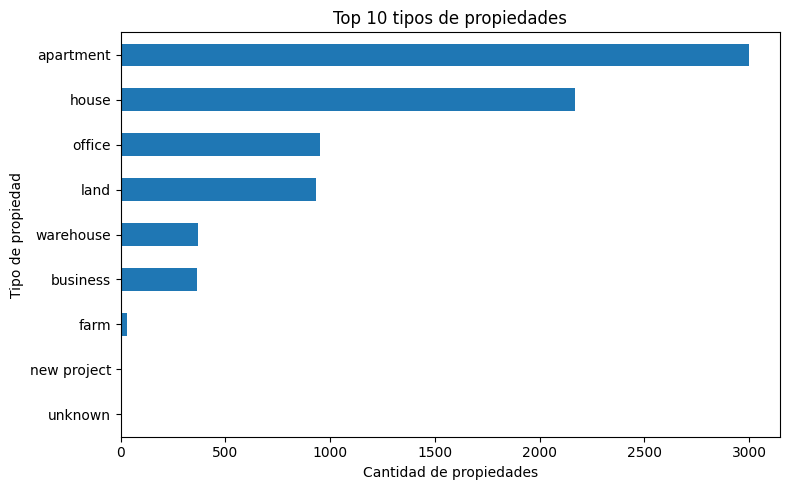

In [22]:
plt.figure(figsize=(8, 5))
vb = df["property_type"].value_counts().head(10)
vb.iloc[::-1].plot(kind="barh")
plt.xlabel("Cantidad de propiedades")
plt.ylabel("Tipo de propiedad")
plt.title("Top 10 tipos de propiedades")
plt.tight_layout()
plt.show()

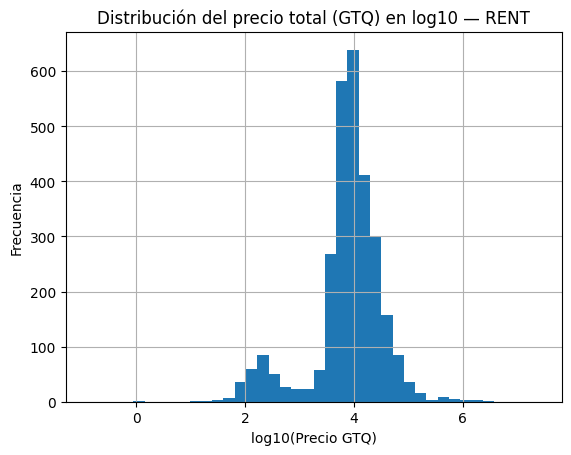

In [23]:
t = df["type"].astype(str).str.strip().str.lower()

s_all = df["price_gtq"].dropna()
s_all = s_all[s_all > 0]
log_all = np.log10(s_all)
bins = np.histogram_bin_edges(log_all, bins=40)

rent_mask = t.isin(["rent"])
s = df.loc[rent_mask, "price_gtq"].dropna()
s = s[s > 0]

plt.figure()
np.log10(s).hist(bins=bins)
plt.xlabel("log10(Precio GTQ)")
plt.ylabel("Frecuencia")
plt.title("Distribución del precio total (GTQ) en log10 — RENT")
plt.show()


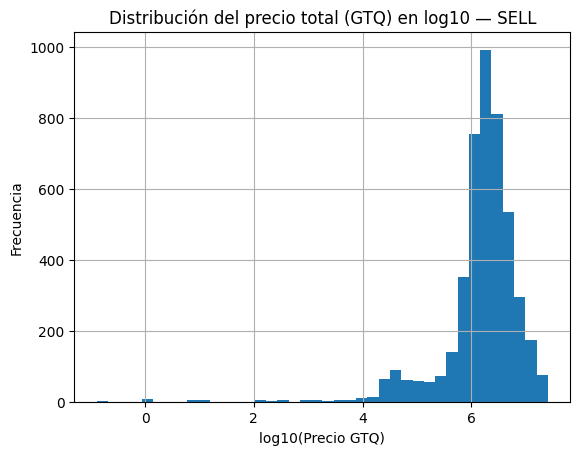

In [24]:
t = df["type"].astype(str).str.strip().str.lower()

s_all = df["price_gtq"].dropna()
s_all = s_all[s_all > 0]
log_all = np.log10(s_all)
bins = np.histogram_bin_edges(log_all, bins=40)

sell_mask = t.isin(["sell"])
s = df.loc[sell_mask, "price_gtq"].dropna()
s = s[s > 0]

plt.figure()
np.log10(s).hist(bins=bins)
plt.xlabel("log10(Precio GTQ)")
plt.ylabel("Frecuencia")
plt.title("Distribución del precio total (GTQ) en log10 — SELL")
plt.show()
